In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCH = 20
BATCH_SIZE = 32
print(DEVICE)

cuda


In [3]:
np_x = np.load('./data_feature_all_hour_new.npy').astype(np.float32)
np_y = np.load('./data_feature_all_hour_target.npy').astype(np.float32)
print(np_x.shape)
print(np_y.shape)
train_spilt_index = int(np_x.shape[0] * 0.8)
train_dataset = TensorDataset(torch.from_numpy(np_x[:train_spilt_index]), torch.from_numpy(np_y[:train_spilt_index].reshape(-1,1)))
test_dataset = TensorDataset(torch.from_numpy(np_x[train_spilt_index:]), torch.from_numpy(np_y[train_spilt_index:].reshape(-1,1)))
trainLoader = DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE)
testLoader = DataLoader(dataset=test_dataset, batch_size = BATCH_SIZE)

(3768, 48, 184)
(3768,)


In [4]:
class MedicModel(torch.nn.Module):

    def __init__(self) -> None:
        super(MedicModel, self).__init__()
        self.batch_norm = torch.nn.BatchNorm1d(48)
        self.norm1 = torch.nn.LayerNorm(184)
        self.norm2 = torch.nn.LayerNorm(256)
        self.norm3 = torch.nn.LayerNorm(128)
        self.lstm_184 = torch.nn.LSTM(184, 256, batch_first = True)
        self.lstm_128 = torch.nn.LSTM(256, 128, batch_first = True)
        self.attentionLayer = torch.nn.MultiheadAttention(embed_dim=128, num_heads=1, batch_first=True)
   
        self.linear_i = torch.nn.Linear(48 * 128, 60)
        self.linear_o = torch.nn.Linear(60, 1)

    def forward(self,x):
        h = self.batch_norm(x)
        h = self.norm1(x)
        h, (_, _) = self.lstm_184(x)
        h = torch.tanh(h)
        h = self.norm2(h)
        h, (_, _) = self.lstm_128(h)
        h = torch.tanh(h)
        h = self.norm3(h)
        
        atten_out, s = self.attentionLayer(h, h, h)
        h = torch.tanh(h)
        h = torch.flatten(h, start_dim=1)
        h = self.linear_i(h)
        h = torch.tanh(h)
        h = self.linear_o(h)
        return h

In [5]:
model = MedicModel().to(DEVICE)

In [6]:
opti = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-2)
loss_fn = torch.nn.BCEWithLogitsLoss()
train_losses = []
test_losses = []

In [7]:
for epoch in tqdm(range(EPOCH)):
    trainTloss = 0.
    testTloss = 0.
    for x, y in trainLoader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opti.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opti.step()
        trainTloss += loss.item()
    with torch.no_grad():
        for x, y in testLoader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            loss = loss_fn(pred, y)
            testTloss += loss.item()
    train_losses.append(trainTloss / (len(trainLoader.dataset)//BATCH_SIZE))
    test_losses.append(testTloss / (len(testLoader.dataset)//BATCH_SIZE))


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


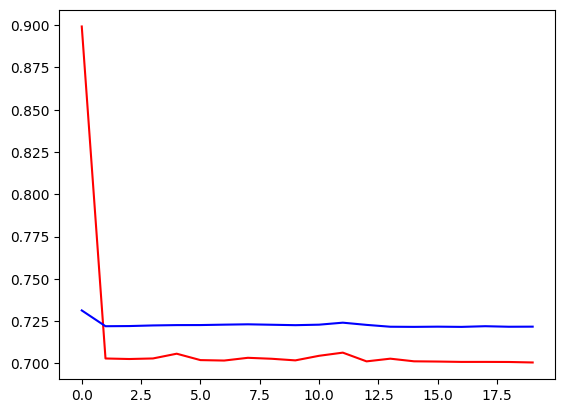

In [8]:
plt.plot(train_losses, color = 'r')
plt.plot(test_losses, color = 'b')
plt.show()

In [9]:
model.eval()

MedicModel(
  (batch_norm): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm1): LayerNorm((184,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lstm_184): LSTM(184, 256, batch_first=True)
  (lstm_128): LSTM(256, 128, batch_first=True)
  (attentionLayer): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (linear_i): Linear(in_features=6144, out_features=60, bias=True)
  (linear_o): Linear(in_features=60, out_features=1, bias=True)
)

In [10]:
correct = 0.
for x, y in trainLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).type(torch.float32).sum()
print(correct.item()/len(trainLoader.dataset))

0.5298606502986065


In [11]:
correct = 0.
for x, y in testLoader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = model(x)
    pred = torch.sigmoid(pred)
    correct += ((pred > 0.5) == y).type(torch.float32).sum()
print(correct.item()/len(testLoader.dataset))

0.5291777188328912


In [12]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [13]:
with torch.no_grad():
    x, y = testLoader.dataset[:]
    x = x.to(DEVICE)
    pred = torch.sigmoid(model(x))
    pred = pred.cpu()
    fpr, tpr, thr = roc_curve(y_true = y, y_score=pred)
    print(fpr)
    print(tpr)
    print(thr)

[0. 1.]
[0. 1.]
[1.4587963  0.45879632]


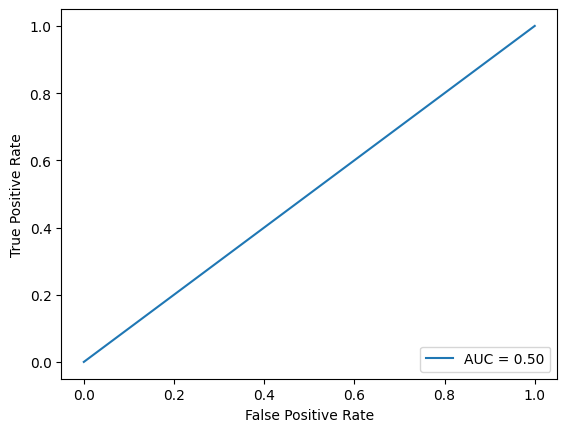

In [14]:
roc_auc = auc(fpr, tpr)
result = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc)
result.plot()